In [62]:
import specq_dev.specq.shared as specq
from specq_dev.specq.jax import JaxBasedPulseSequence, JaxBasedPulse
import pennylane as qml
from jax import numpy as jnp
import jax
from dataclasses import dataclass
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")

In [113]:
initial_state = jnp.array(
    specq.State.from_label("1")
)

In [114]:
qubit_info = specq.QubitInformationV3(
    unit="GHz",
    qubit_idx=0,
    anharmonicity=-0.20640003780600244,
    frequency=5.243573073693335,
    drive_strength=0.11219693508250457,
)

In [115]:

def drag_envelope(amp: float, sigma: float, beta: float, center: float):

    g = lambda t: amp * jnp.exp(-((t - center) ** 2) / (2 * sigma**2))
    f_prime = lambda t: g(t) + 1j * beta * (-1 * (t - center) / sigma**2) * g(t)

    # return f_prime
    return lambda t: amp * (f_prime(t) - f_prime(-1)) / (1 - f_prime(-1))

@dataclass
class JaxDragPulse(JaxBasedPulse):
    total_length: int
    base_amp: float
    base_sigma: float
    base_beta: float
    total_amps: int

    min_amp: float = -1
    max_amp: float = 1

    def __post_init__(self):
        self.t_eval = jnp.arange(self.total_length)
        self.base_drag = drag_envelope(
            amp=self.base_amp, sigma=self.base_sigma, beta=self.base_beta, center=self.total_length // 2
        )(self.t_eval)

    def sample_params(self, key: jax.Array) -> specq.ParametersDictType:

        params: specq.ParametersDictType = dict()

        shifted_amps = jax.random.uniform(key, (self.total_amps, 2), jnp.float32, self.min_amp, self.max_amp)

        for i in range(self.total_amps):
            param = {
                f'amp/real/{i}': float(shifted_amps[i, 0]),
                f'amp/imag/{i}': float(shifted_amps[i, 1]),
            }
            params.update(param)

        return params

    def get_waveform(self, params: specq.ParametersDictType) -> jnp.ndarray:
        
        # Turn params to array with real and imaginary parts
        amps = jnp.array([params[f'amp/real/{i}'] + 1j * params[f'amp/imag/{i}'] for i in range(self.total_amps)])
        # Zero pad to total length
        amps = jnp.pad(amps, (0, self.total_length - self.total_amps))
        # Add base drag
        amps = amps + self.base_drag
        
        return amps

drive_str = qubit_info.drive_strength
dt = 2 / 9
total_length = 80
amp = 0.8
area = 1 / (2 * drive_str * amp) / dt
sigma = (1 * area) / (amp * jnp.sqrt(2 * jnp.pi))

pulse_sequence = JaxBasedPulseSequence(
    pulses=[
        JaxDragPulse(
            total_length=total_length,
            base_amp=amp,
            base_sigma=float(sigma),
            base_beta=0,
            total_amps=80,
            min_amp=0,
            max_amp=0,
        )
    ],
    pulse_length_dt=total_length,
)

key = jax.random.PRNGKey(0)
params = pulse_sequence.sample_params(key)
waveform = pulse_sequence.get_waveform(params)
# modulate the waveform to be signal with sin(vt)
# t = jnp.linspace(0, total_length * dt, total_length)
# signal = waveform * jnp.sin(qubit_info.frequency * t)

In [144]:
signal = lambda params, t, qubit_freq: jnp.real(
    jnp.exp(1j * 2 * jnp.pi * qubit_freq * t)
    * qml.pulse.pwc((0, total_length * dt))(params, t)
)

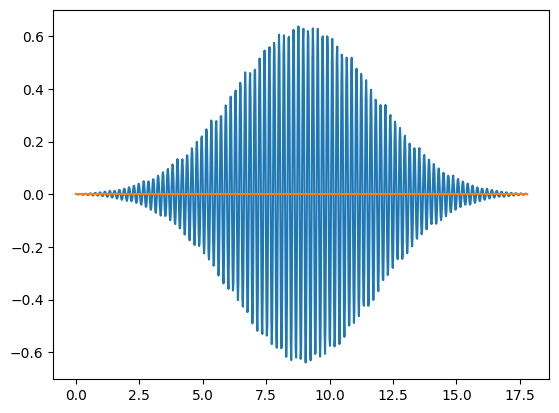

In [145]:
t = jnp.linspace(0, total_length * dt, 1000)
y = signal(waveform, t, qubit_info.frequency)

plt.plot(t, y.real, label='real')
plt.plot(t, y.imag, label='imag')

In [143]:
def duffling_oscillator_hamiltonian(
    qubit_info: specq.QubitInformationV3,
    signal: callable,
) -> qml.pulse.parametrized_hamiltonian.ParametrizedHamiltonian:
    static_hamiltonian = (
        2
        * jnp.pi
        * qubit_info.frequency
        * qml.jordan_wigner(qml.FermiC(0) * qml.FermiA(0))
    )
    drive_hamiltonian = (
        2
        * jnp.pi
        * qubit_info.drive_strength
        * qml.jordan_wigner(qml.FermiC(0) + qml.FermiA(0))
    )

    return static_hamiltonian + signal * drive_hamiltonian

def rotating_duffling_oscillator_hamiltonian(
    qubit_info: specq.QubitInformationV3, signal: callable
) -> qml.pulse.parametrized_hamiltonian.ParametrizedHamiltonian:
    a0 = 2 * jnp.pi * qubit_info.frequency
    a1 = 2 * jnp.pi * qubit_info.drive_strength

    f3 = lambda params, t: a1 * signal(params, t)  # * ((a0 * t / 2)**2)
    f_sigma_x = lambda params, t: f3(params, t) * jnp.cos(a0 * t)
    f_sigma_y = lambda params, t: f3(params, t) * jnp.sin(a0 * t)

    return f_sigma_x * qml.PauliX(0) + f_sigma_y * qml.PauliY(0)

def transmon_hamiltonian(
    qubit_info: specq.QubitInformationV3, waveform: callable
) -> qml.pulse.parametrized_hamiltonian.ParametrizedHamiltonian:
    H_0 = qml.pulse.transmon_interaction(
        qubit_freq=[qubit_info.frequency], connections=[], coupling=[], wires=[0]
    )
    H_d0 = qml.pulse.transmon_drive(
        waveform, 0, qubit_info.frequency, 0
    )  # NOTE: f2 must be real function.

    return H_0 + H_d0

dev = qml.device("default.qubit.jax", wires=1)
H = rotating_duffling_oscillator_hamiltonian(qubit_info, signal)
num_parameterized = len(H.coeffs_parametrized)
 
@jax.jit
@qml.qnode(dev, interface="jax")
def trajectory(
        params: jnp.ndarray, 
        t: jnp.ndarray, 
        initial_state: jnp.ndarray
    ):
    # Prepare the state
    qml.StatePrep(initial_state, wires=0)
    # Evolve the state under the Hamiltonian
    qml.evolve(H)([params] * num_parameterized, t, return_intermediate=True)
    # Measure the expectation values of PauliX, PauliY, and PauliZ
    return (
        qml.expval(qml.PauliX(0)),
        qml.expval(qml.PauliY(0)),
        qml.expval(qml.PauliZ(0)),
    )

def simulate(waveforms: jnp.array):

    initial_states_str = ["+", "-", "r", "l", "0", "1"]
    initial_states = [jnp.array(
        specq.State.from_label(state)
    ) for state in initial_states_str]

    # Set up the simulator
    total_length = waveforms.shape[1]
    t_eval = jnp.linspace(0, total_length * dt, total_length)
    # Batch the trajectory function
    batched_trajectory = jax.vmap(trajectory, in_axes=(0, None, None), out_axes=0)

    expectation_values = {}
    # For each initial state and waveform, calculate the expectation values of PauliX, PauliY, and PauliZ
    for initial_state_str, initial_state in zip(initial_states_str, initial_states):
        exp_X, exp_Y, exp_Z = batched_trajectory(waveforms, t_eval, initial_state)
        expectation_values[initial_state_str] = {
            "X": exp_X[:, -1],
            "Y": exp_Y[:, -1],
            "Z": exp_Z[:, -1],
        }

    return expectation_values

@jax.jit
@qml.qnode(dev, interface="jax")
def whitebox(
        params: jnp.ndarray, 
        t: jnp.ndarray, 
        initial_state: jnp.ndarray
    ):
    # Prepare the state
    qml.StatePrep(initial_state, wires=0)
    # Evolve the state under the Hamiltonian
    qml.evolve(H)([params] * num_parameterized, t, return_intermediate=True)
    # Return the density matrix
    return qml.density_matrix(wires=[0])

def whitebox_v2(
        params: jnp.ndarray, 
        t: jnp.ndarray, 
        H: qml.pulse.parametrized_hamiltonian.ParametrizedHamiltonian,
    ):
    # Evolve under the Hamiltonian
    unitary = qml.evolve(H)([params] * num_parameterized, t, return_intermediate=True)
    # Return the unitary
    return qml.matrix(unitary)

def calculate_exp(unitary: jnp.ndarray, operator: jnp.ndarray, initial_state: jnp.ndarray) -> jnp.ndarray:
    density_matrix = jnp.outer(initial_state, initial_state.T.conj())
    rho = jnp.matmul(unitary, jnp.matmul(density_matrix, unitary.T.conj()))
    temp = jnp.matmul(rho, operator)
    return jnp.trace(temp).real


In [122]:
t = jnp.linspace(0, total_length * dt, 80)

exp_X, exp_Y, exp_Z = trajectory(
    waveform, t=t, initial_state=initial_state
)


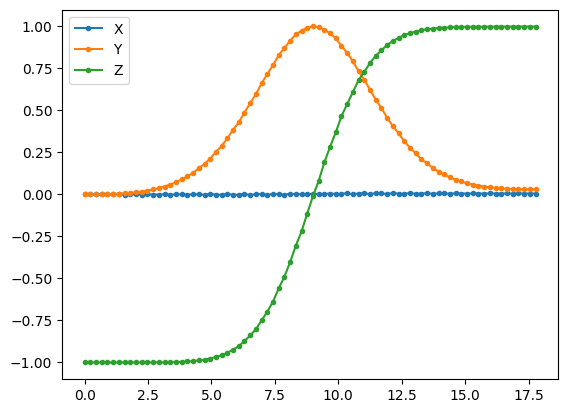

In [123]:
plt.plot(t, exp_X, '.-', label="X")
plt.plot(t, exp_Y, '.-',label="Y")
plt.plot(t, exp_Z, '.-',label="Z")
plt.legend()

In [141]:
def Wo_2_level(params: dict[str, float]) -> jnp.ndarray:
    
    alpha = params["alpha"]
    theta = params["theta"]
    beta = params["beta"]

    lambda_1 = params["lambda_1"]
    lambda_2 = params["lambda_2"]

    q_00 = jnp.exp(1j * alpha) * jnp.cos(theta)
    q_01 = jnp.exp(1j * beta) * jnp.sin(theta)
    q_10 = jnp.exp(-1j * beta) * jnp.sin(theta)
    q_11 = -jnp.exp(-1j * alpha) * jnp.cos(theta)

    Q = jnp.array([[q_00, q_01], [q_10, q_11]])

    D = jnp.array([[lambda_1, 0], [0, lambda_2]])

    return Q @ D @ Q.T.conj()

def expval(density_matrix: jnp.ndarray, operator: jnp.ndarray) -> jnp.ndarray:
    return jnp.trace(density_matrix @ operator).real

Wo = Wo_2_level({
    "alpha": 0,
    "theta": 0,
    "beta": 0,
    "lambda_1": 1,
    "lambda_2": 1,
})

density_matrix = jnp.outer(initial_state, initial_state.T.conj())

expval(Wo @ density_matrix, jnp.array(specq.Operator.from_label("X")))

Array(0., dtype=float64)

In [140]:
def test_cross_check_whiteboxes():

    initial_state = specq.State.from_label("1")
    qubit_info = specq.QubitInformationV3(
        unit="GHz",
        qubit_idx=0,
        anharmonicity=-0.20640003780600244,
        frequency=5.243573073693335,
        drive_strength=0.11219693508250457,
    )

    drive_str = qubit_info.drive_strength
    dt = 2 / 9
    total_length = 80
    amp = 0.8
    area = 1 / (2 * drive_str * amp) / dt
    sigma = (1 * area) / (amp * jnp.sqrt(2 * jnp.pi))

    pulse_sequence = JaxBasedPulseSequence(
        pulses=[
            JaxDragPulse(
                total_length=total_length,
                base_amp=amp,
                base_sigma=float(sigma),
                base_beta=0,
                total_amps=80,
                min_amp=0,
                max_amp=0,
            )
        ],
        pulse_length_dt=total_length,
    )

    key = jax.random.PRNGKey(0)
    params = pulse_sequence.sample_params(key)
    waveform = pulse_sequence.get_waveform(params)

    t = jnp.linspace(0, total_length * dt, 80)

    exp_X, exp_Y, exp_Z = trajectory(
        waveform, t=t, initial_state=initial_state
    )

    jitted_whitebox_v2 = jax.jit(whitebox_v2)
    unitary = jitted_whitebox_v2(waveform, t=t)

    batch_calculate_exp = jax.vmap(calculate_exp, in_axes=(0, None, None))

    exp_X_2 = batch_calculate_exp(unitary, jnp.array(specq.Operator.from_label("X")), initial_state)
    exp_Y_2 = batch_calculate_exp(unitary, jnp.array(specq.Operator.from_label("Y")), initial_state)
    exp_Z_2 = batch_calculate_exp(unitary, jnp.array(specq.Operator.from_label("Z")), initial_state)

    assert jnp.allclose(exp_X, exp_X_2, atol=1e-4)
    assert jnp.allclose(exp_Y, exp_Y_2, atol=1e-4)
    assert jnp.allclose(exp_Z, exp_Z_2, atol=1e-4)

test_cross_check_whiteboxes()

In [149]:
def get_simulator(
    qubit_info: specq.QubitInformationV3,
    t_eval: jnp.ndarray,
):
    fixed_freq_signal = lambda params, t: signal(params, t, qubit_info.frequency)
    H = rotating_duffling_oscillator_hamiltonian(qubit_info, fixed_freq_signal)

    simulator = lambda params: whitebox_v2(params, t_eval, H)

    return simulator

t_eval = jnp.linspace(0, total_length * dt, 80)
simulator = get_simulator(qubit_info, t_eval)

In [150]:
jitted_simulator = jax.jit(simulator)

unitary = jitted_simulator(waveform)

In [151]:
unitary.shape

(80, 2, 2)